In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.data import *
from proofreader.utils.vis import *
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
test2 = np.load('/mnt/home/jberman/ceph/pf/CURVENET_ns2_cs3_t4_aligned_1/data/test.npy', allow_pickle=True).item()
valid2 = np.load('/mnt/home/jberman/ceph/pf/CURVENET_ns2_cs3_t4_aligned_1/data/test.npy', allow_pickle=True).item()

test1 = np.load('/mnt/home/jberman/ceph/pf/CURVENET_ns1_cs3_t4_aligned_0/data/test.npy', allow_pickle=True).item()
valid1 = np.load('/mnt/home/jberman/ceph/pf/CURVENET_ns1_cs3_t4_aligned_0/data/test.npy', allow_pickle=True).item()
all_runs = {1: (test1, valid1), 2: (test2, valid2)}

In [142]:
sns.set()
sns.color_palette("tab10")
FIG_SIZE = (8,6)

In [135]:
def plot_metric_vs_threshold(run_data, metric):

    # global plot params
    plt.figure(figsize=FIG_SIZE)
    plt.title(metric)
    plt.xlabel('Threshold')
    plt.ylabel(f'% Reduction in {metric}')
    plt.xlim((0.0, 1.1))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    for run, data in run_data.items():
        x, y, = data
        x = x[:-1]
        y = y[:-1]

        plt.plot(x,y, zorder=1, label=f'Gap={run}')

        # highlight max
        max_i = np.argmax(y)
        plt.scatter(x[max_i], y[max_i], color='g', s=32, zorder=2)
        plt.annotate(f"{round(y[max_i]*100,1)}%", (x[max_i], y[max_i]), textcoords="offset points",  xytext=(
                    4,8), ha='center')
    plt.legend()
    plt.show()

In [187]:
def plot_merge_curve(run_data, metric, thresholds):

    # global plot params
    plt.figure(figsize=FIG_SIZE)
    plt.title(metric)
    plt.xlabel('Merge Error')
    plt.ylabel(f'Merge Success')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    plt.scatter(None, None, s=32, zorder=2, linewidths=3, edgecolors='g', facecolors='none', label='Best VOI')

    for itr, (run, data) in enumerate(run_data.items()):
        x, y, opt_i = data
        x = x[:-1]
        y = y[:-1]

        plt.plot(x,y, zorder=1, label=f'Gap={run}')
        plt.scatter(x[opt_i], y[opt_i], s=56, zorder=2, linewidths=6, edgecolors='g', facecolors='none')

        # add points
        plt.scatter(x, y, c=thresholds, s=32, zorder=2)
        if itr == 0:
            for i in range(len(thresholds)):
                plt.annotate(f"{round(thresholds[i],2)}", (x[i], y[i]), textcoords="offset points",  xytext=(
                    -16,8),  ha='center')


    plt.legend(loc='lower right')
    plt.show()

In [137]:

def get_optimal_data_from_epochs(test, valid):
    best_e = 0
    best_voi = float('inf')
    for epoch, (x, y) in enumerate(valid['Voi Total']):
        min_voi = min(y)
        if min_voi < best_voi:
            best_e = epoch
            best_voi = min_voi
    total = len(valid['Voi Total']) 
    print(f'optimal epoch: {best_e}/{total}')
    opt = {}
    for k in test.keys():
        opt[k] = (np.array(test[k][best_e][0]), np.array(test[k][best_e][1]))
    return opt

In [138]:
def covert_to_percent_reduction(x):
    no_action = x[-1]
    reduction = no_action - x
    percent_reduction = reduction/no_action
    return percent_reduction

In [139]:
def gen_plt_for_metric(all_runs, metric):
    run_data = {} # r1 -> (r1_x, r1_y)
    for run, data in all_runs.items():
        opt = get_optimal_data_from_epochs(*data)
        x, y = opt[metric]
        y = covert_to_percent_reduction(y)
        run_data[run] = (x, y)
    plot_metric_vs_threshold(run_data, metric)

In [157]:
def gen_plt_for_merge(all_runs):
    run_data = {} # r1 -> (r1_x, r1_y)
    for run, data in all_runs.items():
        opt = get_optimal_data_from_epochs(*data)
        opt_i = np.argmin(opt['Voi Total'][1])
        x, y = opt['merge_curve']
        run_data[run] = (y, x, opt_i)
    thresholds = np.arange(0.1,1,0.1)
    plot_merge_curve(run_data, 'Merge Curve per Threshold', thresholds)

optimal epoch: 23/24
optimal epoch: 19/24


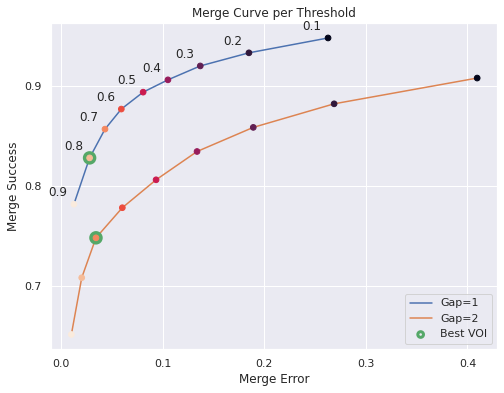

optimal epoch: 23/24
optimal epoch: 19/24


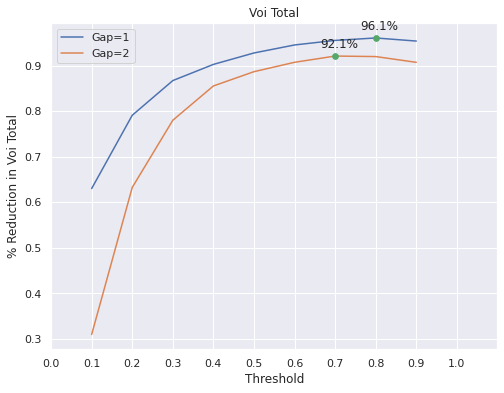

optimal epoch: 23/24
optimal epoch: 19/24


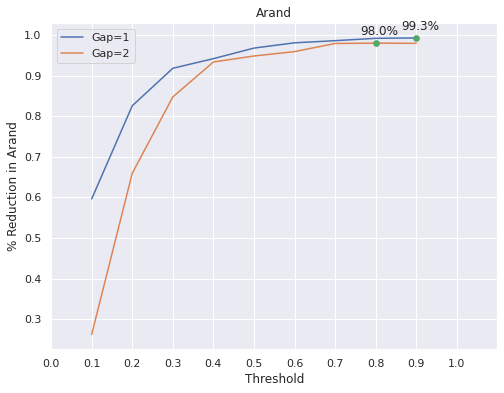

In [188]:
gen_plt_for_merge(all_runs)
gen_plt_for_metric(all_runs, 'Voi Total')
gen_plt_for_metric(all_runs, 'Arand')

In [ ]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, test_vols = prepare_cremi_vols('/mnt/home/jberman/sc/proofreader/dataset/cremi')

In [ ]:
from proofreader.run.metrics import *
vol = test_vols[0]
for i in range(vol.shape[0]):
    split = vol.copy()
    split[i:] += np.max(vol)

    s,m = voi(split, vol)
    arand = adapted_rand(split, vol)
    print(f'split at i={i} normal voi, arand', s+m, arand)

In [ ]:
vol = test_vols[0][:8][:500][:500]
for i in range(vol.shape[0]):
    split = vol.copy()
    split[i:] += np.max(vol)

    s,m = voi(split, vol)
    arand = adapted_rand(split, vol)
    print(f'split at i={i} normal voi, arand', s+m, arand)